# Willman 1: Member sample

Import necessary packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) # display whole table in line
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon

import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

import membership_utils
import properties_utils
import wil1_properties
from wil1_properties import aax, bax, r_half, alpha, ecc, dist, ra_w1, dec_w1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

## Open data & data overview

In [3]:
# open deimos data evaluated for membership
full_deimos = pd.read_csv("data/dmost_alldata_evaluated.csv", index_col = 0)

In [5]:
member_mask    = (full_deimos["prob_member"] >= 0.5)
sixrhalf_mask  = (full_deimos["hl_radius_ell"] <= 6)
onerhalf_mask  = (full_deimos["hl_radius_ell"] <= 1)
gaia_mask      = (full_deimos["gaia_pmra_err"] > 0) & (full_deimos["pm_err_flag"] == 0)
mult_mask      = (full_deimos["flag_var"] != -99) # (full_deimos["nmask"] > 1)
variable       = (full_deimos["flag_var"] == 1)

member_tot          = full_deimos[member_mask]
w1_members          = full_deimos[member_mask & sixrhalf_mask & ~variable]
gaia_members        = full_deimos[member_mask & gaia_mask & ~variable]
rhalf_members       = full_deimos[member_mask & onerhalf_mask & ~variable] # mult_mask
mems_meas, mems_var = full_deimos[member_mask & mult_mask], full_deimos[member_mask & variable]

print("Members + gaia:                        {}".format(len(full_deimos[member_mask & gaia_mask])))
print("Members, <1rhalf:                      {}".format(len(full_deimos[member_mask & onerhalf_mask])))
print("Members, <1rhalf, mult epochs, no var: {}".format(len(full_deimos[member_mask & onerhalf_mask & mult_mask & ~variable])))
print("Members, mult epochs:                  {}".format(len(mems_meas)))
print("Member (<6 rhalf, no var):             {}".format(len(w1_members)))
print("Members total:                         {}".format(len(member_tot)))
print("{} variable(s) out {} measured.\n".format(len(mems_var), len(mems_meas)))

Members + gaia:                        7
Members, <1rhalf:                      28
Members, <1rhalf, mult epochs, no var: 19
Members, mult epochs:                  37
Member (<6 rhalf, no var):             50
Members total:                         56
6 variable(s) out 37 measured.



## Comparison to literature samples

In [6]:
# open Willman 2011 sample data
published_sample = pd.read_csv("data/2011_published_sample.csv")
published_mwfgs = pd.read_csv("data/2011_mwforeground_sample.csv")

Comparison with published 2011 sample:

In [7]:
# astropy coordinates of published, deimos data
c_published = SkyCoord(published_sample["ra"], published_sample["dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["RA"], full_deimos["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_published.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_published  = foo[d2d < 1.5 * u.arcsec]
match_deimos = index[d2d < 1.5 * u.arcsec]

# new df with matched deimos/gaia data
published_data_match = published_sample.iloc[match_published]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_published_combined = pd.concat([published_data_match, deimos_data_match.set_axis(published_data_match.index)], axis = 1)

print(f"{len(deimos_published_combined)} matches out of {len(published_sample)} 2011 members.")

45 matches out of 45 2011 members.


In [8]:
member_2011 = deimos_published_combined[deimos_published_combined["sample"] == 1]
nonmember_2011 = deimos_published_combined[(deimos_published_combined["sample"] == 0) | np.isnan(deimos_published_combined["sample"])]

print(f"2011 members in exclusive sample: {len(member_2011)}")
print(f"Variable stars in 2011 member sample: {np.sum(deimos_published_combined["flag_var"] == 1)}")
print(f"2011 members labeled non-members: {len(nonmember_2011)}")

2011 members in exclusive sample: 32
Variable stars in 2011 member sample: 4
2011 members labeled non-members: 13


In [9]:
nonmember_2011

,Unnamed: 0,ra,dec,r_mag,gr_mag,v_helio,system_name,objname,RA,DEC,nmask,nexp,t_exp,masknames,slitwidth,mean_mjd,collate1d_filename,SN,serendip,marz_flag,marz_z,v,v_err,verr_rand,v_chi2,phot_source,phot_type,gmag_o,rmag_o,gmag_err,rmag_err,EBV,MV_o,rproj_arcm,rproj_kpc,ew_naI,ew_naI_err,ew_mgI,ew_mgI_err,ew_cat,ew_cat_err,ew_feh,ew_feh_err,ew_w1,ew_w2,ew_w3,ew_gl,tmpl_teff,tmpl_feh,gaia_source_id,gaia_pmra,gaia_pmra_err,gaia_pmdec,gaia_pmdec_err,gaia_pmra_pmdec_corr,gaia_parallax,gaia_parallax_err,gaia_aen,gaia_aen_sig,gaia_phot_variable_flag,gaia_rv,gaia_rv_err,gaia_grvs_mag,var_pval,var_max_v,var_max_t,var_short_max_t,flag_short_var,flag_coadd,flag_var,flag_gaia,flag_HB,Pmem_cmd,Pmem_EW,Pmem_parallax,Pmem_pm,Pmem_feh,Pmem_v,Pmem,Pmem_novar,delta_ra_cosdec,delta_dec,cmd_marker,feh_marker,hl_radius_circ,hl_radius_ell,parallax_marker,perp_dist_iso,pm_err_flag,pm_marker,pos_angle,prob_member,prob_nomet,prob_nov,r_proj,radius,radius_ell,sample,v_marker
2,3a,162.428625,51.072778,18.19,0.65,-13.3,b'W1',b'645',162.428804,51.072915,3,13,21600.0,b'W1_6+W1_1+203WiSB',0.70,57869.285096,b'J104942.91+510422.49_DEIMOS_20170426_2017042...,133.535492,0,1,-0.000273,-11.231301,0.647219,0.082920,1.668561,b'munozf',b' ',18.863292,18.234666,0.0028,0.0031,0.011260,0.713163,3.491867,0.037278,5.132044e-01,0.061083,0.603865,0.050000,6.271462,0.056735,-0.713113,0.118027,1.380430,2.837807,2.183089,2.0,5165.986771,-0.50000,835977627109780224,-3.500088,0.096136,-1.562649,0.137677,-0.076237,0.364983,0.142346,0.261795,8.112828e-01,b'NOT',0.0,0.0,0.0,-0.119868,1.101752,95687.293486,2.158416,0,0,0,1,0,0.909647,1,1,0.515145,1.000000,0.994530,0.466036,0.0,0.053563,0.022815,0.829886,0.311223,1.391700,1.411489,1.0,0.091638,0.0,0.000000,6.071666,0.000000,0.000000,0.000000,1.383893,0.058219,0.058219,0.0,0.994096
3,4a,162.301667,51.095278,18.21,0.63,-7.4,b'W1',b'id',162.301660,51.095583,4,16,27000.0,b'W1_9+W1_6+W1_3+203WiSB',0.70,59312.321405,b'J104912.40+510544.10_DEIMOS_20210408_2021040...,144.227183,0,1,-0.000281,-8.660338,0.560813,0.074436,1.807436,b'munozf',b' ',18.857466,18.275207,0.0030,0.0028,0.012046,0.730335,3.155334,0.033685,5.726014e-01,0.050000,0.677221,0.050000,6.362232,0.050000,-0.670149,0.116822,1.379499,2.829988,2.159863,2.0,5500.000000,-0.37486,836722782460563840,-8.038897,0.097997,-6.423261,0.141399,-0.145307,0.367003,0.141733,0.000000,3.332220e-15,b'NOT',0.0,0.0,0.0,-0.072481,1.294870,130320.164907,2.158416,0,0,0,1,0,0.968485,1,1,0.001629,1.000000,0.971947,0.001534,0.0,-0.026365,0.045483,0.923664,0.289063,1.256703,2.326934,1.0,0.059800,0.0,0.000000,103.099327,0.000000,0.000000,0.000000,-0.284819,0.052572,0.052572,0.0,0.959581
5,6a,162.452208,51.008889,19.05,0.39,-2.1,b'W1',b'id',162.452269,51.009063,2,10,18000.0,b'W1_9+W1_2',0.70,59312.321405,b'J104948.54+510032.63_DEIMOS_20210408_2021040...,55.485057,0,1,-0.000278,-8.216515,0.867040,0.262278,1.845986,b'munozf',b' ',19.433143,19.058051,0.0029,0.0033,0.010656,1.408767,4.781650,0.051047,3.532172e-01,0.062325,0.359773,0.052052,4.943317,0.103929,-1.115248,0.123760,0.919861,2.044064,1.595551,2.0,6000.000000,-0.50000,835976454583288832,-1.789179,0.167181,0.295219,0.228222,-0.047899,-0.138819,0.221731,0.000000,0.000000e+00,b'NOT',0.0,0.0,0.0,-0.228910,0.935403,126041.878358,2.144400,0,0,0,1,0,0.809897,1,1,0.578377,1.000000,0.966388,0.452680,0.0,0.068314,-0.041037,0.705249,0.555719,1.904986,2.959485,1.0,0.125410,0.0,0.000000,312.006344,0.000000,0.000000,0.000000,1.274841,0.079692,0.079692,0.0,0.950779
10,11a,162.354042,51.156389,20.60,0.44,-4.9,b'W1',b'262',162.354000,51.156611,1,3,5400.0,b'W1_3',1.00,54061.569246,b'J104924.96+510923.80_DEIMOS_20061122_2006112...,18.711985,0,1,-0.002513,-4.765024,2.207844,0.000000,1.194177,b'munozf',b' ',21.007065,20.618437,0.0048,0.0047,0.011957,2.975975,6.403609,0.068362,2.029291e-01,0.082294,-99.000000,99.000000,3.608153,0.229251,-1.369339,0.164512,0.840591,1.707196,1.060366,1.0,6000.000000,-1.00000,836729551328690432,-1.594703,0.693524,-2.037330,0.983220,-0.279721,0

13 non-members based on: proper motion (4), velocity (2), large verr (1), no velocity (6)
- 3a: proper motion
- 4a: proper motion
- 6a: proper motion
- 11a: proper motion
- 18: updated velocity
- 31: no velocity
- 32: updated velocity
- 35: large v_err
- 36: no velocity
- 38: no velocity
- 43: no velocity
- 44: no velocity
- 45: no velocity

Metallicity comparison:

Star 1, 2011: [Fe/H] = $-1.73 \pm 0.12$ dex

Star 2, 2011: [Fe/H] = $-2.65 \pm 0.12$ dex

Star 8, 2001: [Fe/H] = $-1.92 \pm 0.21$ dex

In [10]:
print(member_2011.loc[[0, 1, 7]]["ew_feh"])
print(member_2011.loc[[0, 1, 7]]["ew_feh_err"])

0   -2.262133
1   -2.518148
7   -2.428865
Name: ew_feh, dtype: float64
0    0.117760
1    0.117594
7    0.149938
Name: ew_feh_err, dtype: float64


Comparison with published 2011 Milky Way foreground stars:

In [11]:
# astropy coordinates of published, deimos data
c_published = SkyCoord(published_mwfgs["ra"], published_mwfgs["dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["RA"], full_deimos["DEC"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_published.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_published  = foo[d2d < 1.5 * u.arcsec]
match_deimos = index[d2d < 1.5 * u.arcsec]

# new df with matched deimos/gaia data
published_data_match = published_mwfgs.iloc[match_published]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_published_combined = pd.concat([published_data_match, deimos_data_match.set_axis(published_data_match.index)], axis = 1)

print(f"{len(deimos_published_combined)} matches out of {len(published_mwfgs)} 2011 Milky Way foregrounds.")

51 matches out of 52 2011 Milky Way foregrounds.


In [12]:
deimos_published_combined[deimos_published_combined["sample"] == 1]

,Unnamed: 0,ra,dec,r_mag,gr_mag,v_helio,system_name,objname,RA,DEC,nmask,nexp,t_exp,masknames,slitwidth,mean_mjd,collate1d_filename,SN,serendip,marz_flag,marz_z,v,v_err,verr_rand,v_chi2,phot_source,phot_type,gmag_o,rmag_o,gmag_err,rmag_err,EBV,MV_o,rproj_arcm,rproj_kpc,ew_naI,ew_naI_err,ew_mgI,ew_mgI_err,ew_cat,ew_cat_err,ew_feh,ew_feh_err,ew_w1,ew_w2,ew_w3,ew_gl,tmpl_teff,tmpl_feh,gaia_source_id,gaia_pmra,gaia_pmra_err,gaia_pmdec,gaia_pmdec_err,gaia_pmra_pmdec_corr,gaia_parallax,gaia_parallax_err,gaia_aen,gaia_aen_sig,gaia_phot_variable_flag,gaia_rv,gaia_rv_err,gaia_grvs_mag,var_pval,var_max_v,var_max_t,var_short_max_t,flag_short_var,flag_coadd,flag_var,flag_gaia,flag_HB,Pmem_cmd,Pmem_EW,Pmem_parallax,Pmem_pm,Pmem_feh,Pmem_v,Pmem,Pmem_novar,delta_ra_cosdec,delta_dec,cmd_marker,feh_marker,hl_radius_circ,hl_radius_ell,parallax_marker,perp_dist_iso,pm_err_flag,pm_marker,pos_angle,prob_member,prob_nomet,prob_nov,r_proj,radius,radius_ell,sample,v_marker
30,76,162.264208,51.013333,21.53,0.14,7.4,b'W1',b'37',162.264208,51.0135,1,5,9000.0,b'W1_1',1.0,54059.576457,b'J104903.41+510048.60_DEIMOS_20061120_2006112...,8.4685,0,1,-0.000173,-3.255432,7.06433,0.0,1.432554,b'munozf',b' ',21.650171,21.579885,0.0065,0.0087,0.011876,3.774158,3.714646,0.039656,0.176788,0.174126,0.220101,0.167572,1.284926,99.0,-999.0,-999.0,0.155876,0.846131,0.282919,1.0,7000.0,-1.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,b' ',-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.569744,0,1,-99,-99,0,0.770468,1,1,1.0,1.0,0.887702,0.683946,1.0,-0.049909,-0.0366,0.636108,NaN,1.479457,1.672749,NaN,0.143053,NaN,NaN,199.253982,0.53289,0.53289,0.636108,-1.396706,0.061891,0.061891,1.0,0.837736


## Completeness tests

In [88]:
# analyze full deimos data
full_deimos["radius"]         = np.nan      # distance to center of Wil1 [deg]
full_deimos["radius_ell"]     = np.nan      # distance to center, calculated from elliptical radii [deg]
full_deimos["hl_radius_circ"] = np.nan      # distance to center of Wil1 [half-light radii]
full_deimos["hl_radius_ell"]  = np.nan      # half-light elliptical radius
full_deimos["r_proj"]         = np.nan      # projected half-light radius
full_deimos["pos_angle"]      = np.nan      # position angle (deg)

# calculate spatial properties for each star
for index, row in full_deimos.iterrows():
    radius, ell_radius, hl_radius_circular, hl_radius_elliptical, proj_distance, p_angle = \
        membership_utils.spatial_prop(row["delta_ra_cosdec"], row["delta_dec"], 0, 0, r_half, -alpha, aax, ecc)
    
    full_deimos.loc[index, "radius"]         = radius
    full_deimos.loc[index, "radius_ell"]     = ell_radius
    full_deimos.loc[index, "hl_radius_circ"] = hl_radius_circular
    full_deimos.loc[index, "hl_radius_ell"]  = hl_radius_elliptical
    full_deimos.loc[index, "r_proj"]         = proj_distance
    full_deimos.loc[index, "pos_angle"]      = p_angle

iso_data = pd.read_csv('data/isochrones/parsec_iso.csv')    # read file
gr_iso = iso_data["gr"].values
r_iso  = iso_data["r"].values

iso_data = pd.DataFrame({"gr": gr_iso, "r": r_iso})     # convert isochrone data to pandas df
iso_data.to_csv("data/isochrone_data_0001.csv")

def prob_cmd(min_dist, data_sigma, iso_sigma):
    p_cmd = np.exp(-(min_dist ** 2) / (2 * (iso_sigma ** 2 + data_sigma ** 2)))
    return p_cmd

full_deimos["perp_dist_iso"] = np.nan         # perpendicular distance
full_deimos["cmd_marker"]    = np.nan         # cmd marker

# calculate P_CMD for each star
for index_deimos, row_deimos in full_deimos.iterrows():
    # color, magnitude deimos data
    r_mag = full_deimos.loc[index_deimos, "rmag_o"]
    gr_mag = full_deimos.loc[index_deimos, "gmag_o"] - r_mag
    
    # add error data in quadrature
    r_mag_err = full_deimos.loc[index_deimos, "rmag_err"]
    g_mag_err = full_deimos.loc[index_deimos, "gmag_err"]
    gr_mag_err = (r_mag_err ** 2 + g_mag_err ** 2) ** (0.5)

    # calculate distance from star's cmd location to each point in isochrone
    iso_dists = np.sqrt((r_mag - iso_data["r"]) ** 2 + (gr_mag - iso_data["gr"])**2)
    d_min = np.min(iso_dists)
    full_deimos.loc[index_deimos, "perp_dist_iso"] = d_min

    # set isochrone error, to account for the metallicity spread + age uncertainty (estimated using grid of isochrones)
    iso_stdev = 0.2
    
    if d_min < 3 * iso_stdev: # calculate P_CMD from perpendicular distance
        prob = prob_cmd(d_min, gr_mag_err, iso_stdev)
        full_deimos.loc[index_deimos, "cmd_marker"] = prob
    
    else: # P_CMD = 0 if more than 3 * iso_stdev away from isochrone
        full_deimos.loc[index_deimos, "cmd_marker"] = 0

In [89]:
# manually add in hb star
hb_index = full_deimos[(full_deimos["gmag_o"] - full_deimos["rmag_o"]) < -0.2].index[1]
full_deimos.loc[hb_index, "cmd_marker"]  = 1

In [101]:
# open munoz full photometry
munoz_phot = pd.read_csv("data/munoz_wil1_phot_evaluated.csv", index_col = 0)

In [102]:
# astropy coordinates of munoz, full deimos data
c_phot = SkyCoord(munoz_phot["delta_ra_cos_dec"], munoz_phot["delta_dec"], unit = u.degree)
c_deimos = SkyCoord(full_deimos["delta_ra_cosdec"], full_deimos["delta_dec"], unit = u.degree)

# matching criteria within 1 arcsec
index, d2d, d3d = c_phot.match_to_catalog_sky(c_deimos)
foo = np.arange(0, np.size(index), 1)
match_phot = foo[d2d < 1.*u.arcsec]
match_deimos = index[d2d < 1.*u.arcsec]

# new df with matched munoz/full deimos data
phot_data_match = munoz_phot.iloc[match_phot]
deimos_data_match = full_deimos.iloc[match_deimos]
deimos_phot_combined = pd.concat([phot_data_match, deimos_data_match.set_axis(phot_data_match.index)], axis = 1)

print("{} matches out of {} deimos sources.".format(len(deimos_phot_combined), len(full_deimos)))

508 matches out of 519 deimos sources.


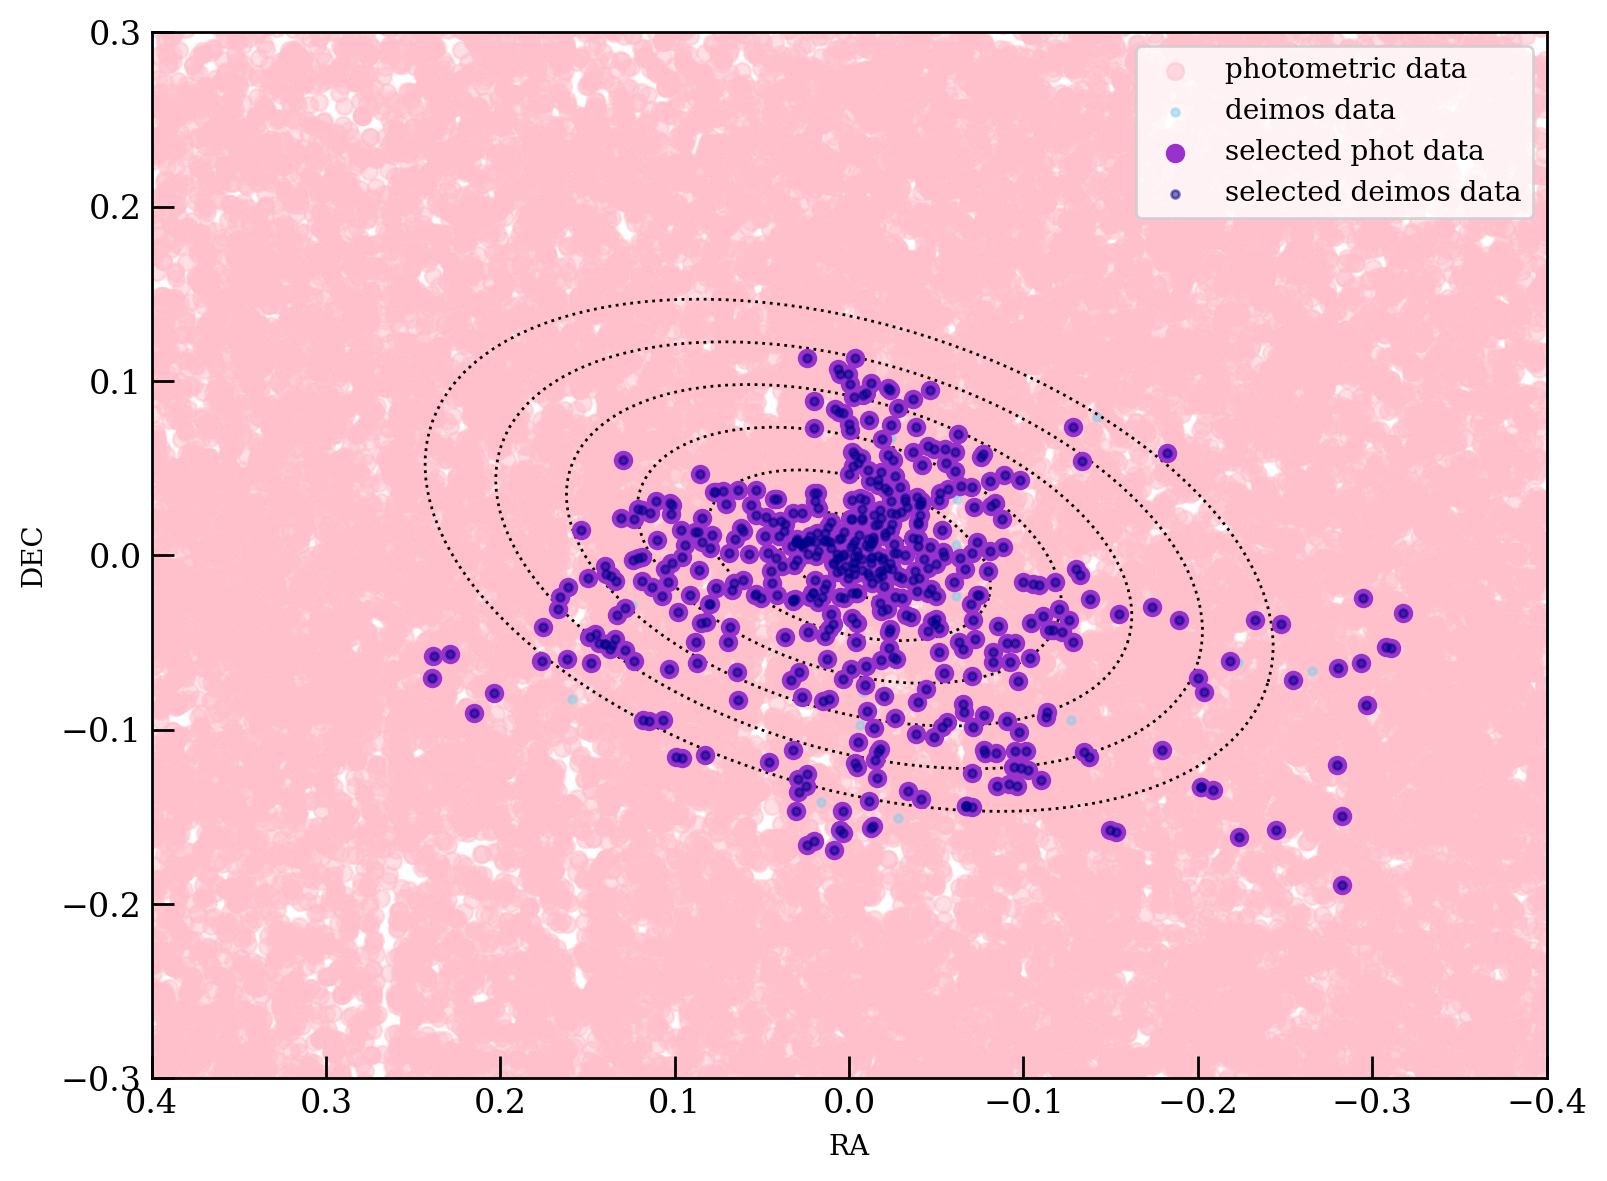

In [103]:
# spatial distribution
fig = plt.figure(figsize = (9, 9))
ax = fig.gca()

ax.set_aspect("equal")

ax.scatter(munoz_phot["delta_ra_cos_dec"], munoz_phot["delta_dec"], 
           c = "pink", alpha = 0.5, zorder = 0, label = "photometric data")
ax.scatter(full_deimos["delta_ra_cosdec"], full_deimos["delta_dec"], 
           c = "skyblue", alpha = 0.5, s = 8, zorder = 1, label = "deimos data")

ax.scatter(deimos_phot_combined["delta_ra_cos_dec"], deimos_phot_combined["delta_dec"].iloc[:, 0], 
           c = "darkorchid", zorder = 3, label = "selected phot data")
ax.scatter(deimos_phot_combined["delta_ra_cosdec"], deimos_phot_combined["delta_dec"].iloc[:, 0], 
           alpha = 0.5, c = "darkblue", s = 8, zorder = 4, label = "selected deimos data")

for ii in range(6): # half-light radii
    jj = 2 * (ii + 1)
    ellipse = Ellipse((0, 0), bax * jj, aax * jj, angle = 360-73, fill = False, linestyle = ":", edgecolor = "black")
    ax.add_patch(ellipse)

ax.set_xlabel("RA", labelpad = 5, size = 10).set_color('black')
ax.set_ylabel("DEC", labelpad = 5, size = 10).set_color('black')

ax.set_xlim(0.4, -0.4)
ax.set_ylim(-0.3, 0.3)

ax.legend(loc = 'upper right', fontsize = 10, frameon = True)

# fig.savefig("deimos_munoz_spatial.pdf", dpi = 600, transparent = True)

(14.0, 26.0)

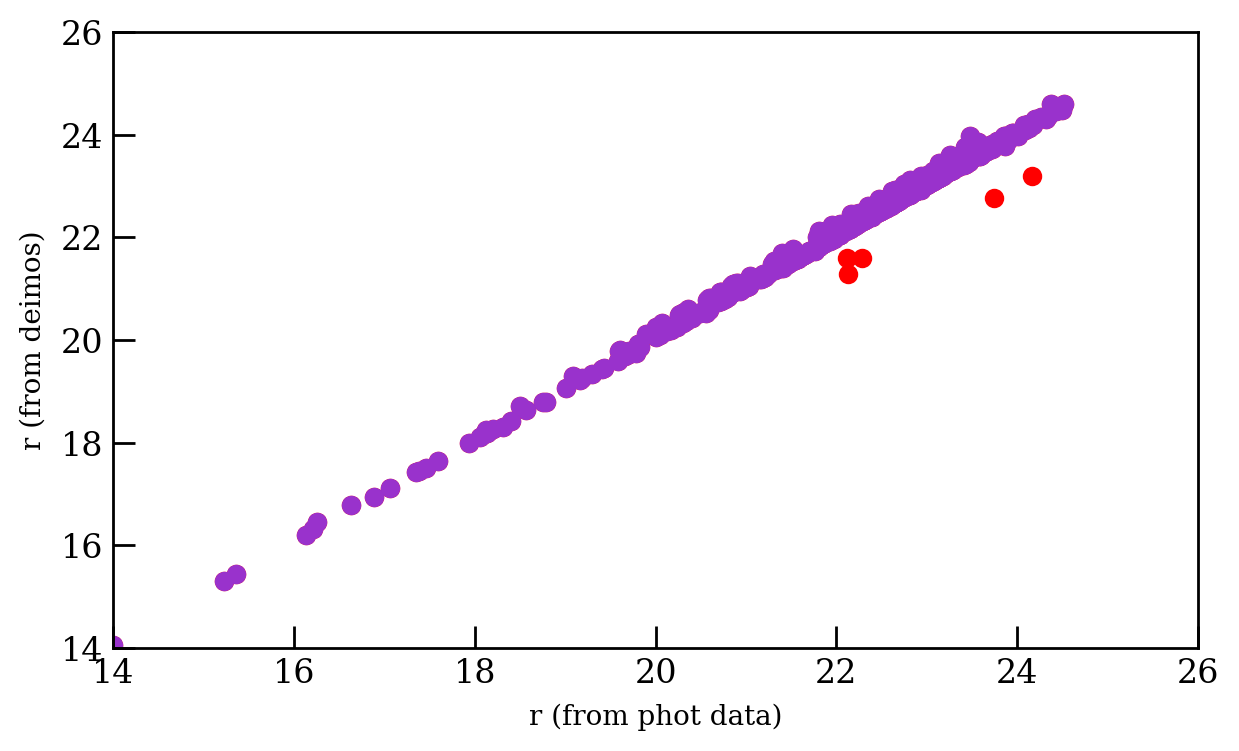

In [104]:
# check color, magnitude values
fig = plt.figure(figsize = (7, 4))
ax = fig.gca()

ax.scatter(deimos_phot_combined["rmag_o"].values[:, 0], deimos_phot_combined["rmag_o"].values[:, 1], c = "red")
deimos_phot_combined = deimos_phot_combined[abs(deimos_phot_combined["rmag_o"].iloc[:, 0] - deimos_phot_combined["rmag_o"].iloc[:, 1]) < 0.5]
ax.scatter(deimos_phot_combined["rmag_o"].values[:, 0], deimos_phot_combined["rmag_o"].values[:, 1], c = "darkorchid")

ax.set_xlabel("r (from phot data)", labelpad = 5, size = 10).set_color('black')
ax.set_ylabel("r (from deimos)", labelpad = 5, size = 10).set_color('black')

ax.set_xlim(14, 26)
ax.set_ylim(14, 26)

# fig.savefig("deimos_munoz_mag.pdf", dpi = 600, transparent = True)

In [105]:
# cut munoz and deimos data to probable members
cut_munoz_phot = munoz_phot[(munoz_phot["hl_radius_ell"] <= 3) & (munoz_phot["cmd_marker"] >= 0.5)]
cut_deimos = full_deimos[(full_deimos["hl_radius_ell"] <= 3) & (full_deimos["cmd_marker"] >= 0.5)]
deimos_phot_combined = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= 3)
                                            & ((deimos_phot_combined["cmd_marker"].iloc[:, 0] >= 0.5) & 
                                               (deimos_phot_combined["cmd_marker"].iloc[:, 1] >= 0.5))]

print("rhalf < 3 and P_CMD > 0.5")
print("-------------------------")
print("Munoz phot :  {} sources".format(len(cut_munoz_phot)))
print("Deimos data : {} sources".format(len(cut_deimos)))
print("Overlap :     {} sources".format(len(deimos_phot_combined)))

rhalf < 3 and P_CMD > 0.5
-------------------------
Munoz phot :  800 sources
Deimos data : 217 sources
Overlap :     206 sources


In [132]:
def cummulative_percent(max_mag):
    percent_df = pd.DataFrame() # new df with empty columns
    percent_df["r_half"] = np.arange(0, 3.1, 0.1)
    percent_df["percent"], percent_df["n_total"], percent_df["n_overlap"] = np.nan, np.nan, np.nan
    
    for i in range(len(percent_df)): # loop through r_half values
        r_max = percent_df.loc[i, "r_half"]
        # calculate total stars in phot data
        total = cut_munoz_phot[(cut_munoz_phot["hl_radius_ell"] <= r_max) & (cut_munoz_phot["rmag_o"] <= max_mag)]
        # calculate stars in deimos data
        sample = cut_deimos[(cut_deimos["hl_radius_ell"] <= r_max) & (cut_deimos["rmag_o"] <= max_mag)]
        # calculate overlap stars
        sample_overlap = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= r_max) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] <= max_mag)]

        if len(total) != 0: # save to dataframe
            percent_df.loc[i, "percent"] = (len(sample_overlap) / len(total))
            percent_df.loc[i, "n_total"] = len(total)
            percent_df.loc[i, "n_overlap"] = len(sample_overlap)

    return percent_df

In [133]:
def discrete_percent(min_mag, max_mag):
    percent_df = pd.DataFrame() # new df with empty columns
    percent_df["r_half"] = np.arange(0, 3.1, 0.1)
    percent_df["percent"], percent_df["n_total"], percent_df["n_overlap"] = np.nan, np.nan, np.nan

    for i in range(len(percent_df)): # loop through r_half values
        r_max = percent_df.loc[i, "r_half"]
        # calculate total stars in phot data
        total = cut_munoz_phot[(cut_munoz_phot["hl_radius_ell"] <= r_max) & 
                               (cut_munoz_phot["rmag_o"] <= max_mag) & (cut_munoz_phot["rmag_o"] >= min_mag)]
        # calculate stars in deimos data
        sample = cut_deimos[(cut_deimos["hl_radius_ell"] <= r_max) & 
                            (cut_deimos["rmag_o"] <= max_mag) & (cut_deimos["rmag_o"] >= min_mag)]
        # calculate overlap stars
        sample_overlap = deimos_phot_combined[(deimos_phot_combined["hl_radius_ell"].iloc[:, 0] <= r_max) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] <= max_mag) & 
                                              (deimos_phot_combined["rmag_o"].iloc[:, 0] >= min_mag)]
        
        if len(total) != 0: # save to dataframe
            percent_df.loc[i, "percent"] = (len(sample_overlap) / len(total))
            percent_df.loc[i, "n_total"] = len(total)
            percent_df.loc[i, "n_overlap"] = len(sample_overlap)

    return percent_df

In [134]:
dp_17_df = cummulative_percent(17)
dp_19_df = cummulative_percent(19)
dp_20_df = cummulative_percent(20)
dp_21_df = cummulative_percent(21)
dp_22_df = cummulative_percent(22)
dp_23_df = cummulative_percent(23)
dp_24_df = cummulative_percent(24)

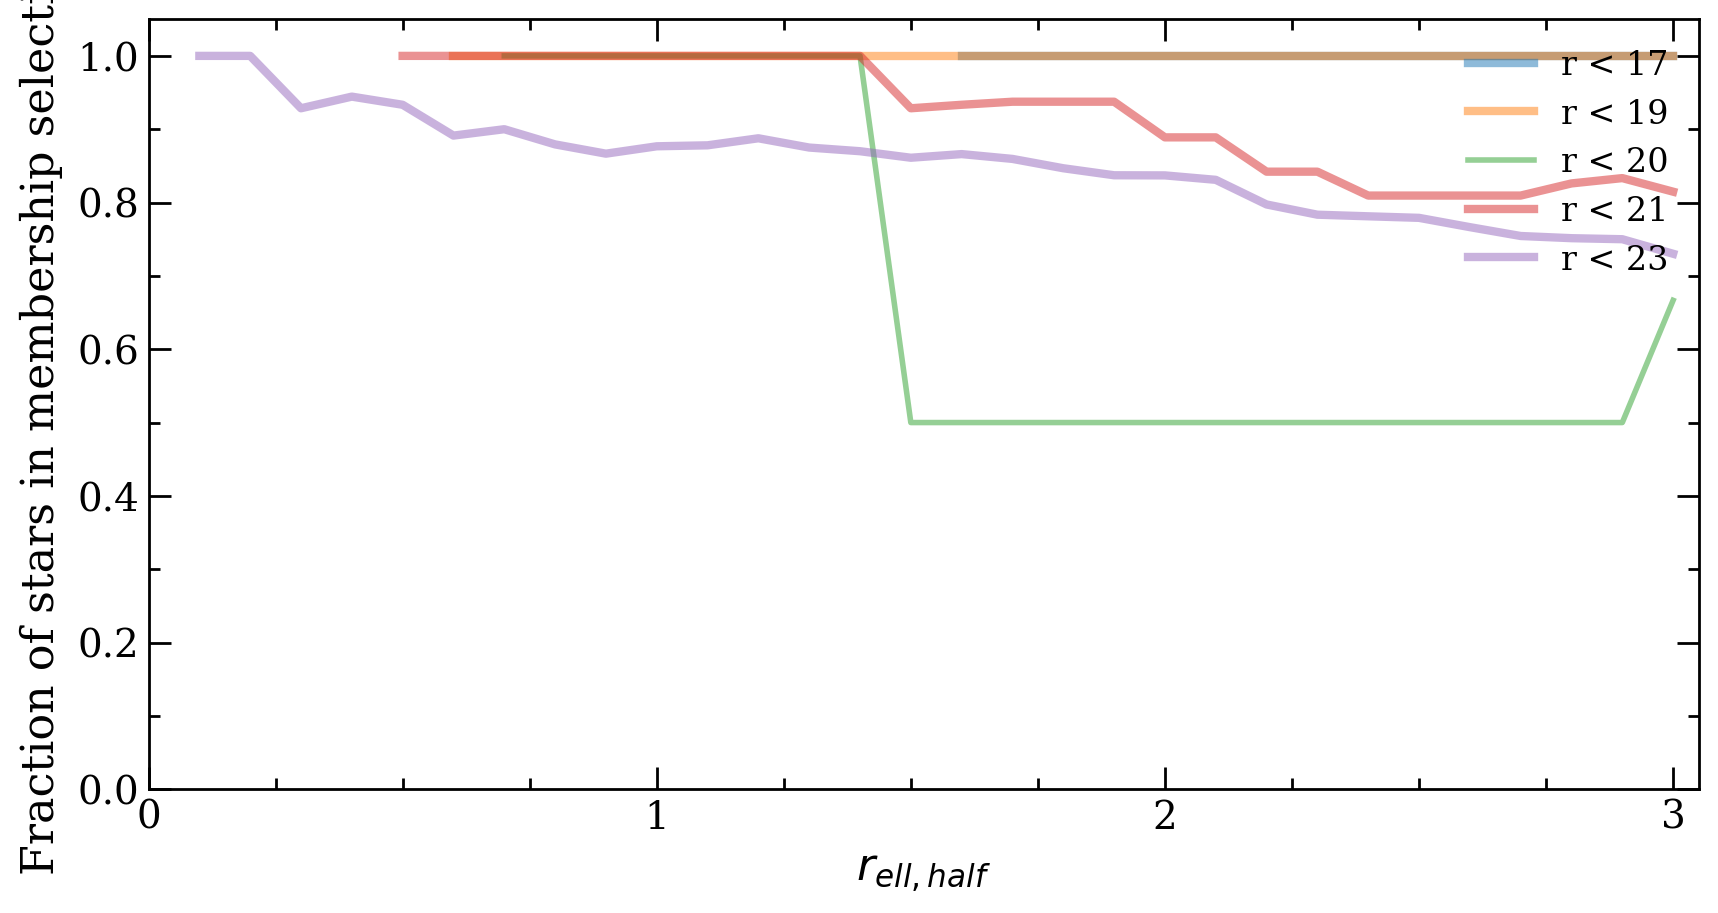

In [144]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

mag_17 = sns.lineplot(x = "r_half", y = "percent", data = dp_17_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 17")
mag_19 = sns.lineplot(x = "r_half", y = "percent", data = dp_19_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 19")
mag_20 = sns.lineplot(x = "r_half", y = "percent", data = dp_20_df, markers = True, alpha = 0.5, linewidth = 2, label = "r < 20")
mag_21 = sns.lineplot(x = "r_half", y = "percent", data = dp_21_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 21")
#mag_22 = sns.lineplot(x = "r_half", y = "percent", data = dp_22_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_23 = sns.lineplot(x = "r_half", y = "percent", data = dp_23_df, markers = True, alpha = 0.5, linewidth = 3, label = "r < 23")
#mag_24 = sns.lineplot(x = "r_half", y = "percent", data = dp_24_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")

#Customizations
ax.set_xlabel("$r_{ell, half}$", labelpad = 5, size = 16)
ax.set_ylabel("Fraction of stars in membership selection", labelpad = 5, size = 16)
ax.set_xlim([0, 3.05])
ax.set_ylim([0, 1.05])

ax.set_xticks(np.arange(0, 4, 1), minor = False)
ax.set_xticks(np.arange(0, 3.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 1.2, 0.2), minor = False)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.legend(loc = "upper right", fontsize = 12, frameon = False)

# fig.savefig("wil1_completeness_cumulative.pdf", dpi = 600, transparent = True)

In [145]:
dp_17_df1 = discrete_percent(0, 17)
dp_19_df1 = discrete_percent(17, 19)
dp_20_df = discrete_percent(19, 20)
dp_21_df1 = discrete_percent(20, 21)
#dp_22_df = discrete_percent(22)
dp_23_df1 = discrete_percent(21, 23)
#dp_24_df = discrete_percent(24)
dp_tot_df1 = discrete_percent(23, 27)

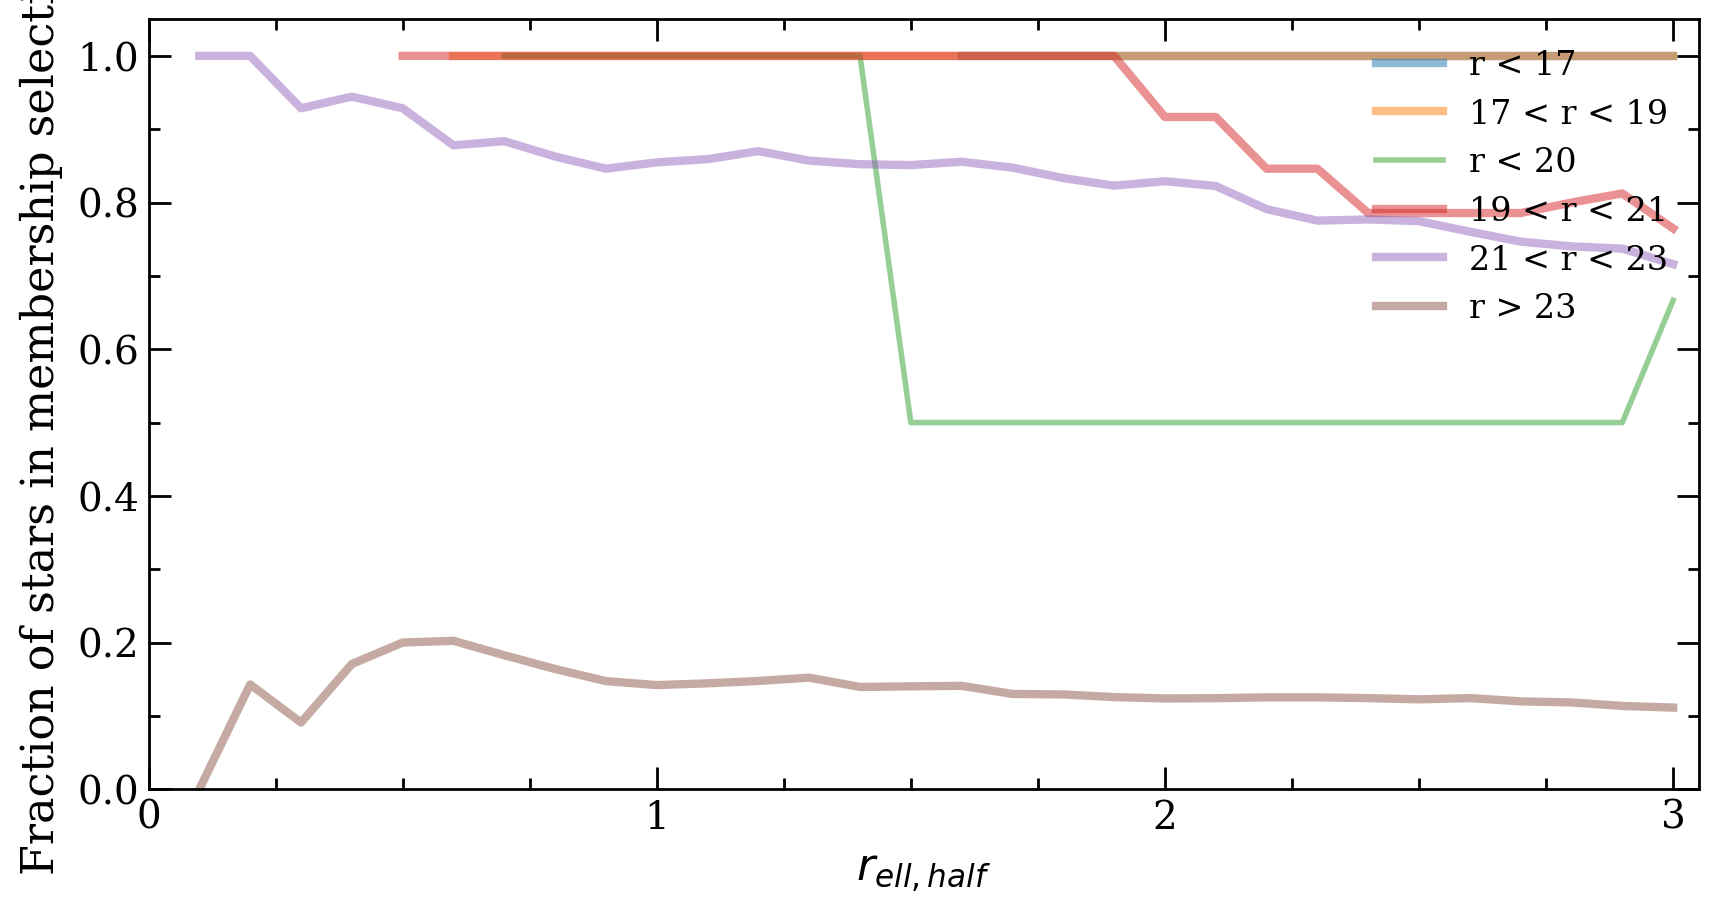

In [147]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

import seaborn as sns
#ax.axvline(x = 0.7, linestyle = "--", c = "black", label = "location of step function")

mag_17 = sns.lineplot(x = "r_half", y = "percent", data = dp_17_df1, markers = True, alpha = 0.5, linewidth = 3, label = "r < 17")
mag_19 = sns.lineplot(x = "r_half", y = "percent", data = dp_19_df1, markers = True, alpha = 0.5, linewidth = 3, label = "17 < r < 19")
mag_20 = sns.lineplot(x = "r_half", y = "percent", data = dp_20_df, markers = True, alpha = 0.5, linewidth = 2, label = "r < 20")
mag_21 = sns.lineplot(x = "r_half", y = "percent", data = dp_21_df1, markers = True, alpha = 0.5, linewidth = 3, label = "19 < r < 21")
#mag_22 = sns.lineplot(x = "r_half", y = "percent", data = dp_22_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_23 = sns.lineplot(x = "r_half", y = "percent", data = dp_23_df1, markers = True, alpha = 0.5, linewidth = 3, label = "21 < r < 23")
#mag_24 = sns.lineplot(x = "r_half", y = "percent", data = dp_24_df, markers = True, alpha = 0.5, linewidth = 2, label = "test")
mag_tot = sns.lineplot(x = "r_half", y = "percent", data = dp_tot_df1, markers = True, alpha = 0.5, linewidth = 3, label = "r > 23")

#Customizations
ax.set_xlabel("$r_{ell, half}$", labelpad = 5, size = 16)
ax.set_ylabel("Fraction of stars in membership selection", labelpad = 5, size = 16)
ax.set_xlim([0, 3.05])
ax.set_ylim([0, 1.05])

ax.set_xticks(np.arange(0, 4, 1), minor = False)
ax.set_xticks(np.arange(0, 3.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 1.2, 0.2), minor = False)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.legend(loc = "upper right", fontsize = 12, frameon = False)

#fig.savefig("wil1_completeness_discrete.pdf", dpi = 600, transparent = True)

In [148]:
len(cut_munoz_phot[(cut_munoz_phot["hl_radius_ell"] < 1) & (cut_munoz_phot["rmag_o"] <= 21) & (cut_munoz_phot["rmag_o"] >= 0) & (cut_munoz_phot["cmd_marker"] > 0.5)])

11

In [149]:
len(cut_deimos[(cut_deimos["hl_radius_ell"] < 1) & (cut_deimos["rmag_o"] <= 21) & (cut_deimos["rmag_o"] >= 0) & (cut_deimos["cmd_marker"] > 0.5)])

11

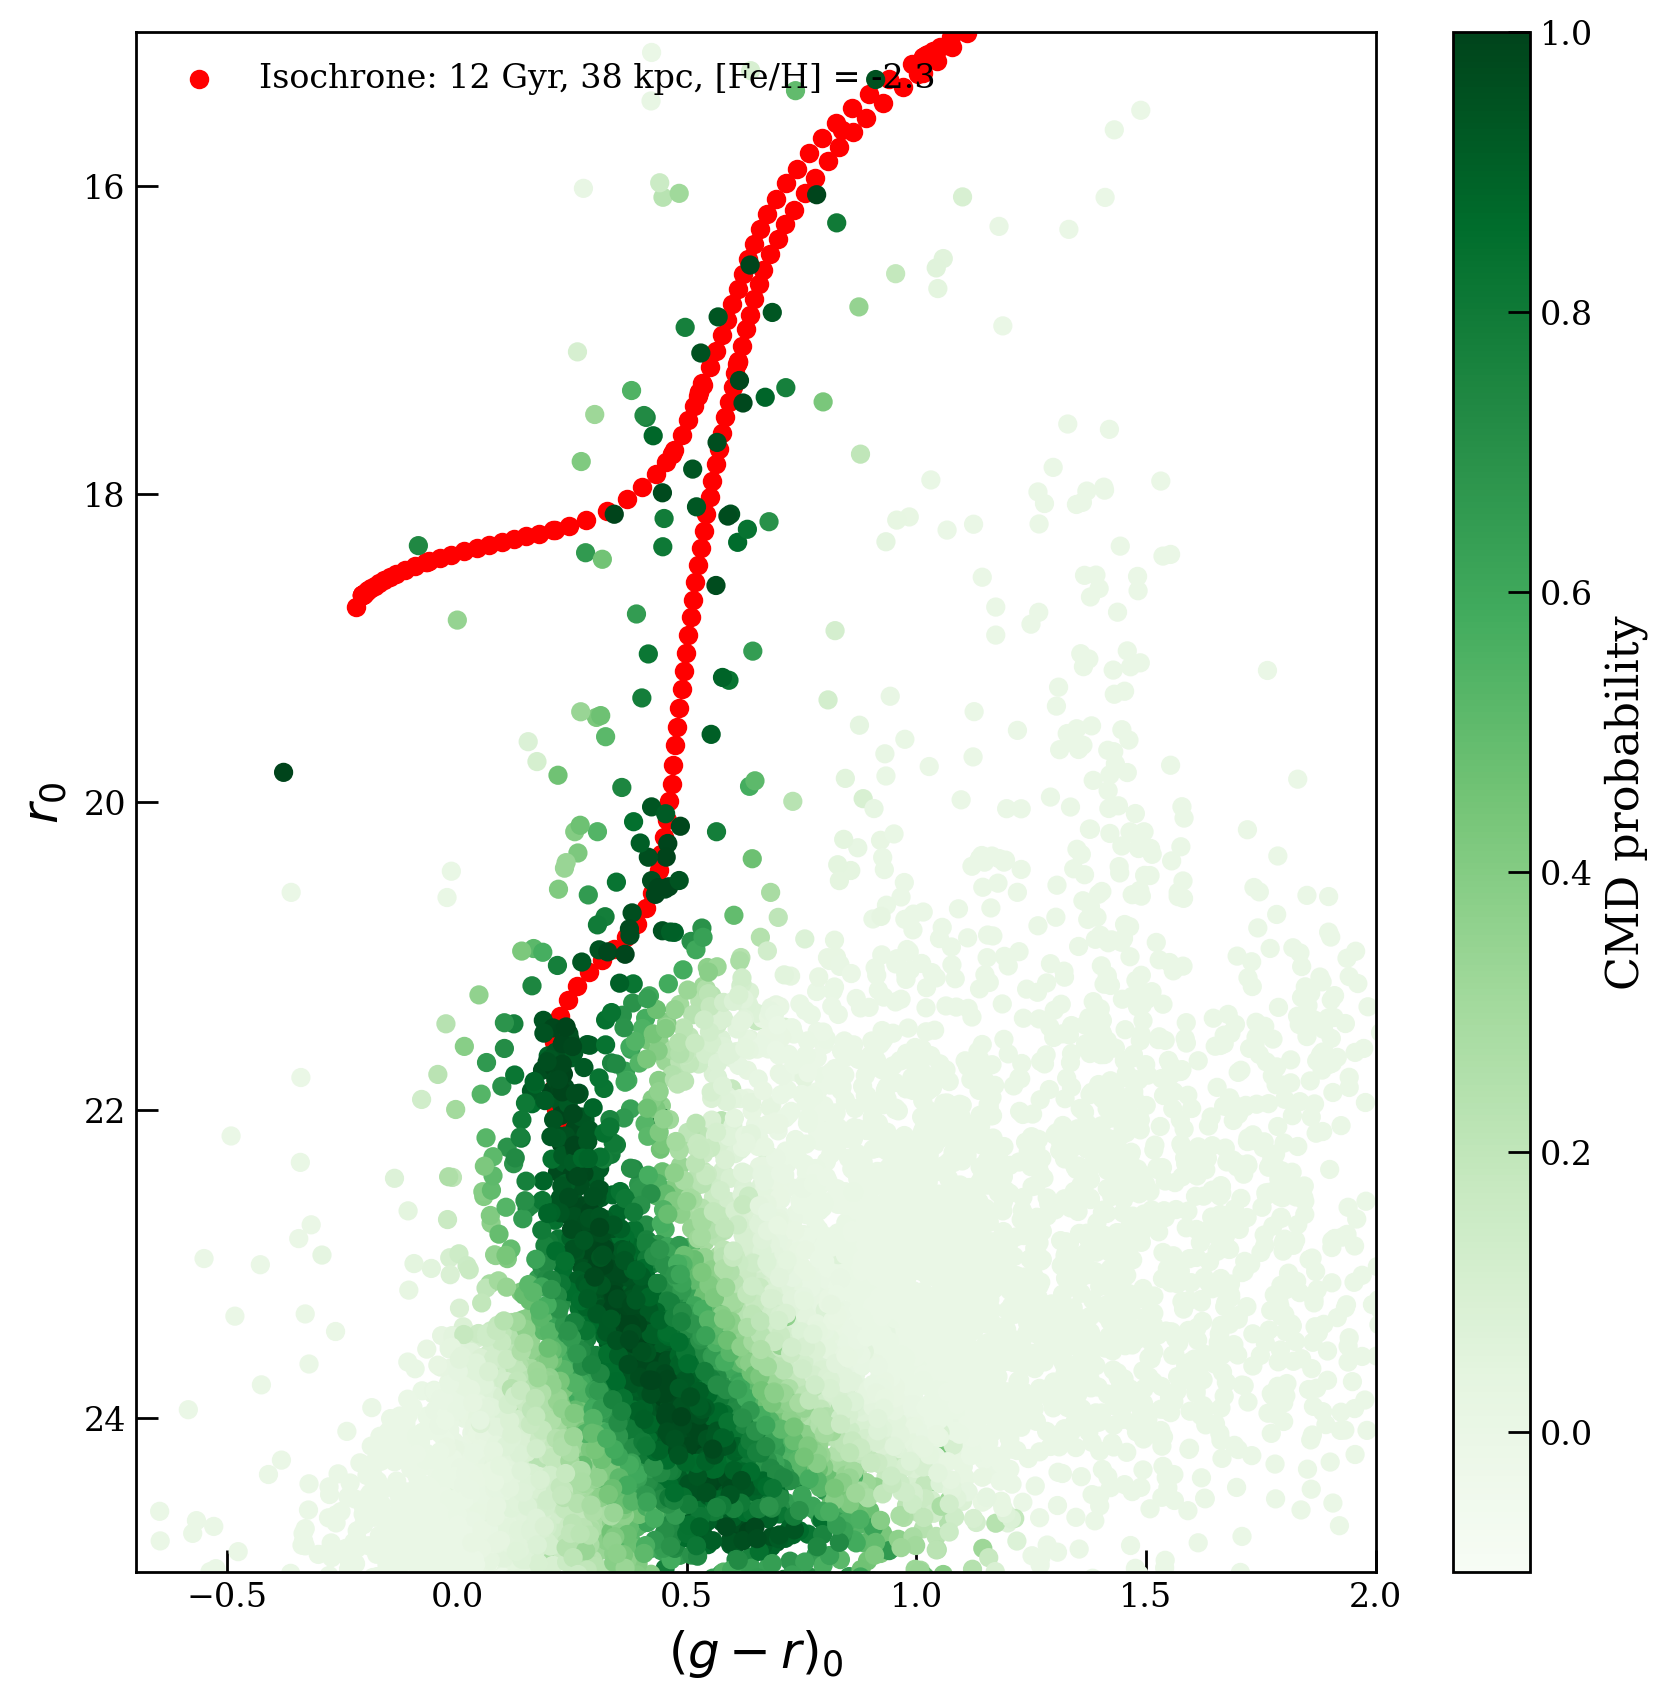

In [150]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

ax.scatter(iso_data["gr"], iso_data["r"], c = "red", label = "Isochrone: 12 Gyr, 38 kpc, [Fe/H] = -2.3") #iso
rhalf_cut_munoz = munoz_phot[munoz_phot["hl_radius_ell"] <= 6]
data = ax.scatter(rhalf_cut_munoz["g"] - rhalf_cut_munoz["r"], rhalf_cut_munoz["r"], c = rhalf_cut_munoz["cmd_marker"], cmap = "Greens", s = 35, vmin = -0.1, vmax = 1, zorder = 2) #full data

ax.set_xlim(-0.7, 2)
ax.set_ylim(25, 15)

ax.set_xlabel("$(g-r)_0$", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("$r_0$", labelpad = 5, size = 18).set_color('black')

cbar = plt.colorbar(data)
cbar.set_label("CMD probability")

ax.legend(loc = 'upper left', fontsize = 12, frameon = False)

#fig.savefig("phot_cmd.pdf", dpi = 600, transparent = True)